In [7]:
# Regular packages
import pandas as pd
import sys
from pathlib import Path
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL


# adds src folder to path
sys.path.append(str(Path.cwd().parent.parent / "src")) # Necessário contar quantos niveis subir nas pastas, incluir 1 .parent para cada nivel.

# My custom functions and classes
from utils.paths import resolve_env_path, PROJECT_ROOT
from classes.time_series_dataset import TimeSeriesDataset
from classes.plotter import Plotter
from utils.calculations import plot_stl_decomposition
from utils.calculations import process_df

# Nixlaverse model utilities
from hierarchicalforecast.core import HierarchicalReconciliation
# from hierarchicalforecast.evaluation import evaluate
from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from utilsforecast.losses import rmse, mae, smape, mase, scaled_crps, mqloss, mape
# from statsforecast.models import AutoETS
# from statsforecast import StatsForecast



# Adiciona caminhos importantes
ARRIVALS_PATH = resolve_env_path("ARRIVALS_PATH")

# Selecting seaborn theme
sns.set_theme(
    style="ticks",
    palette="bright",
    context="notebook"
)


Reading clean dataset


In [8]:
arrivals_dataset = TimeSeriesDataset(ARRIVALS_PATH)
df = arrivals_dataset.get_data_without_missing_values()

Entry route codes

In [111]:
arrivals_dataset.entry_route_table

,entry_route,entry_route_id
0,terrestre,2
1,fluvial,4
2,aereo,1
3,maritimo,3


Continent codes

In [112]:
arrivals_dataset.continent_table

,continent,continent_id
0,africa,1
1,america_central_e_caribe,2
2,america_do_norte,3
3,america_do_sul,4
4,asia,5
5,europa,6
6,oceania,7
7,continente_nao_especificado,8


In [113]:
df

,continent,continent_id,country,country_id,state,state_id,entry_route,entry_route_id,year,month,month_id,arrivals,file_index,date
0,africa,1,africa_do_sul,2,acre,1,terrestre,2,2015,janeiro,1,2.0,file_0,2015-01-01
1,africa,1,angola,6,acre,1,terrestre,2,2015,janeiro,1,0.0,file_0,2015-01-01
2,africa,1,cabo_verde,35,acre,1,terrestre,2,2015,janeiro,1,0.0,file_0,2015-01-01
3,africa,1,egito,60,acre,1,terrestre,2,2015,janeiro,1,0.0,file_0,2015-01-01
4,africa,1,gana,77,acre,1,terrestre,2,2015,janeiro,1,0.0,file_0,2015-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762567,america_do_sul,4,venezuela,238,sao_paulo,25,maritimo,3,2018,agosto,8,0.0,file_24,2018-08-01
762568,america_do_sul,4,venezuela,238,sao_paulo,25,maritimo,3,2018,setembro,9,0.0,file_24,2018-09-01
762569,america_do_sul,4,venezuela,238,sao_paulo,25,maritimo,3,2018,outubro,10,0.0,file_24,2018-10-01
762570,america_do_sul,4,venezuela,238,sao_paulo,25,maritimo,3,2018,novembro,11,0.0,file_24,2018-11-01


## Total arrivals prediction

In [114]:
df_rj = process_df(
    df=df,
    state="rio_de_janeiro",
    value_cols="arrivals",
    agg_func="sum",
    agg_cols="date"
)

df_rj.tail()

,date,arrivals
295,2024-08-01,91504.0
296,2024-09-01,116003.0
297,2024-10-01,130985.0
298,2024-11-01,145148.0
299,2024-12-01,176121.0


### First try: damped trend ETS model for post-covid years. 

Create unique id column and guarantee that time series is sorted.

In [ ]:
df_ets = df_rj.copy()
df_ets["unique_id"] = "rj"
df_ets = df_ets[["unique_id", "date", "arrivals"]].sort_values(["unique_id", "date"])
df_ets = df_ets.query("date >= '2022-01-01'") # Only post covid data
df_ets = df_ets.rename(columns={"date":"ds", "arrivals":"y"})
df_ets.tail()

,unique_id,ds,y
295,rj,2024-08-01,91504.0
296,rj,2024-09-01,116003.0
297,rj,2024-10-01,130985.0
298,rj,2024-11-01,145148.0
299,rj,2024-12-01,176121.0


In [116]:
# AutoETS config
FREQ = "MS"
SEASON_LENGTH = 12   # sazonalidade mensal

# Cross validation configs
H = 12
STEP = 6
N_WINDOWS = 3

Create AutoETS instance:  Since, from the EDA, we know that 2022 was still an atypical year, with strong positive trend, and afterwards things start to be as usual, we'll consider a damped additive trend, that should mimic the described time series behaviour.

In [117]:
autoets = AutoETS(season_length=SEASON_LENGTH, damped=True)

Fitting ETS and performing cross validation

In [118]:
sf = StatsForecast(models=[autoets], freq=FREQ, n_jobs=-1)
cv_df = sf.cross_validation(
    df=df_ets,
    h=H,
    step_size=STEP,
    n_windows=N_WINDOWS,
)

Changing predictions column to y_hat

In [119]:
pred_col = autoets.alias  # normalmente "AutoETS"
cv_eval = cv_df.rename(columns={pred_col: "y_hat"})
cv_eval.head()

,unique_id,ds,cutoff,y,y_hat
0,rj,2023-01-01,2022-12-01,136256.0,95518.573969
1,rj,2023-02-01,2022-12-01,137200.0,99092.143041
2,rj,2023-03-01,2022-12-01,128797.0,102594.240732
3,rj,2023-04-01,2022-12-01,80984.0,106026.296469
4,rj,2023-05-01,2022-12-01,65886.0,109389.711091


In [120]:
metrics_overall = evaluate(
    df=cv_df,
    metrics=[smape, rmse, mae, mape],
    models=[pred_col],
    agg_fn="mean",          # média das perdas ao longo das linhas
    id_col="unique_id",
    time_col="ds",
    target_col="y",
)

Calculating cross validation error metrics.

In [121]:
metrics_overall

,metric,AutoETS
0,smape,0.177445
1,rmse,46031.865643
2,mae,39228.129510
3,mape,0.370888


In [ ]:
sf_final = sf.fit(df_ets)
fcst = sf_final.forecast(df=df_ets, h=H, level=[80, 95])

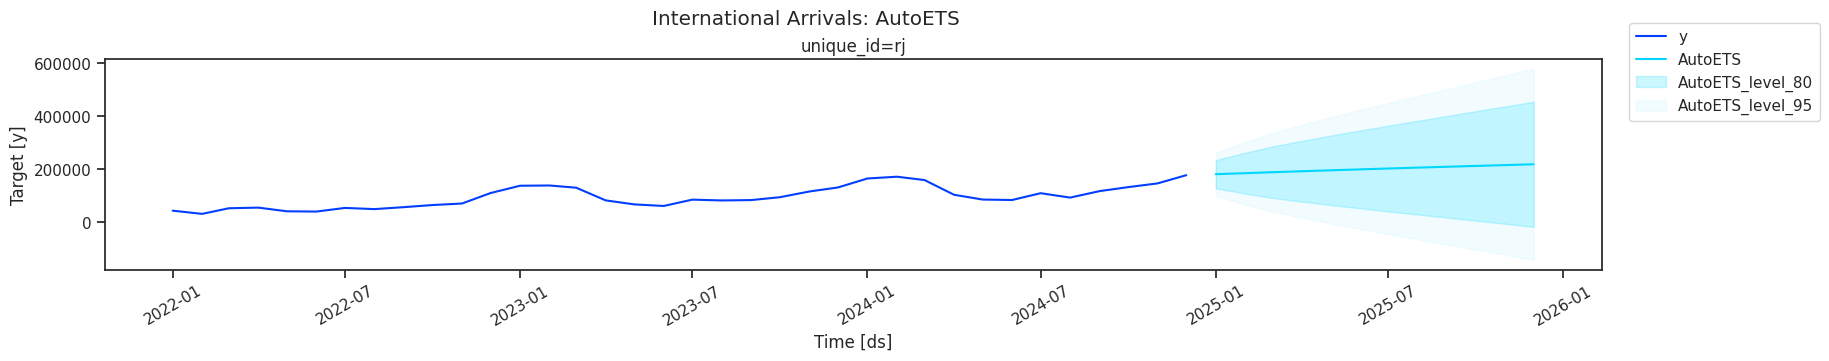

In [ ]:
fig = plot_series(
    df_ets,
    fcst,
    level=[80, 95],
    models=[autoets.alias],
)

fig.suptitle("International Arrivals: AutoETS")
fig


Those predictions are clearly a joke, since we're only training the model with 24 months, and trying to predict 12 months with the ETS model.

In [159]:
autoets = AutoETS(season_length=12, damped=True, model="ZZZ")
autoets = autoets.fit(y=df_ets["y"].values)

Adjusting AutoETS to the whole time series returns a model without seasonality, which doesn't make sense. 

In [169]:
autoets.model_["method"]

'ETS(M,Ad,N)'

TODO: AutoARIMA

In [134]:
dir(autoets)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_conformal_intervals',
 '_add_predict_conformal_intervals',
 '_conformal_method',
 '_conformity_scores',
 '_store_cs',
 'alias',
 'damped',
 'fit',
 'forecast',
 'forward',
 'model',
 'new',
 'phi',
 'predict',
 'predict_in_sample',
 'prediction_intervals',
 'season_length',
 'uses_exog']

In [150]:
sf_final.models[0].model_

AttributeError: 'AutoETS' object has no attribute 'model_'

# SARIMAX Model with COVID Intervention Variable

In [9]:
# Import SARIMAX for time series modeling with intervention
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data Preparation for SARIMAX

In [10]:
# Load and prepare data (assuming you have df_rj from previous analysis)
# If you don't have it, uncomment and run the data loading section

# Load dataset
arrivals_dataset = TimeSeriesDataset(ARRIVALS_PATH)
df = arrivals_dataset.get_data_without_missing_values()

# Process data for Rio de Janeiro
df_rj = process_df(
    df=df, 
    state="rio_de_janeiro", 
    agg_cols=["date","continent","continent_id", "entry_route","entry_route_id", "year", "month", "month_id"], 
    value_cols="arrivals", 
    agg_func="sum"
)

# Create aggregated time series (total arrivals by month)
df_ts = df_rj.groupby("date")["arrivals"].sum().reset_index()
df_ts = df_ts.set_index('date').sort_index()

print(f"Dataset period: {df_ts.index.min()} to {df_ts.index.max()}")
print(f"Total observations: {len(df_ts)}")
df_ts.head()

Dataset period: 2000-01-01 00:00:00 to 2024-12-01 00:00:00
Total observations: 300


,arrivals
date,
2000-01-01,91318.0
2000-02-01,80424.0
2000-03-01,75716.0
2000-04-01,62957.0
2000-05-01,53855.0


In [11]:
# Create COVID intervention variable (2020-01-01 to 2022-12-31)
def create_covid_intervention(dates):
    """
    Create COVID intervention variable for the period 2020-2022
    Returns 1 during COVID period (2020-01 to 2022-12), 0 otherwise
    """
    covid_period = (
        (dates >= '2020-01-01') & 
        (dates <= '2022-12-31')
    ).astype(int)
    
    return covid_period

# Create the intervention variable
covid_intervention = create_covid_intervention(df_ts.index)

# Create a DataFrame with the intervention variable
intervention_df = pd.DataFrame({
    'covid_intervention': covid_intervention
}, index=df_ts.index)

print("COVID intervention variable summary:")
print(f"Total COVID period months: {covid_intervention.sum()}")
print(f"COVID period: {df_ts.index[covid_intervention == 1].min()} to {df_ts.index[covid_intervention == 1].max()}")
print("\nFirst few values:")
print(intervention_df.head(10))

COVID intervention variable summary:
Total COVID period months: 36
COVID period: 2020-01-01 00:00:00 to 2022-12-01 00:00:00

First few values:
            covid_intervention
date                          
2000-01-01                   0
2000-02-01                   0
2000-03-01                   0
2000-04-01                   0
2000-05-01                   0
2000-06-01                   0
2000-07-01                   0
2000-08-01                   0
2000-09-01                   0
2000-10-01                   0


## Train-Test Split

In [12]:
# Split data for training and testing
# Train: 2000-01 to 2023-12 (including COVID period for learning intervention)
# Test: 2024-01 onwards

split_date = '2024-01-01'

# Training data
train_y = df_ts[df_ts.index < split_date]['arrivals']
train_X = intervention_df[intervention_df.index < split_date]

# Test data
test_y = df_ts[df_ts.index >= split_date]['arrivals']
test_X = intervention_df[intervention_df.index >= split_date]

print(f"Training period: {train_y.index.min()} to {train_y.index.max()}")
print(f"Training observations: {len(train_y)}")
print(f"Test period: {test_y.index.min()} to {test_y.index.max()}")
print(f"Test observations: {len(test_y)}")
print(f"COVID observations in training: {train_X['covid_intervention'].sum()}")

Training period: 2000-01-01 00:00:00 to 2023-12-01 00:00:00
Training observations: 288
Test period: 2024-01-01 00:00:00 to 2024-12-01 00:00:00
Test observations: 12
COVID observations in training: 36


## SARIMAX Model Fitting

In [17]:
# Define and fit SARIMAX model with COVID intervention
# Using typical SARIMA parameters for monthly data with seasonality

# SARIMAX(p,d,q)(P,D,Q,s) where s=12 for monthly seasonality
# Starting with conservative parameters
order = (1, 1, 1)           # Non-seasonal ARIMA order (p,d,q)
seasonal_order = (1, 1, 1, 12)  # Seasonal ARIMA order (P,D,Q,s)

print("Fitting SARIMAX model with COVID intervention...")
print(f"ARIMA order: {order}")
print(f"Seasonal order: {seasonal_order}")

# Fit the model
model_sarimax = SARIMAX(
    endog=train_y,
    exog=train_X,
    order=order,
    seasonal_order=seasonal_order,
    trend='c',  # Include constant term
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
fitted_model = model_sarimax.fit(disp=False)

print("Model fitted successfully!")
print(f"Log Likelihood: {fitted_model.llf:.2f}")
print(f"AIC: {fitted_model.aic:.2f}")
print(f"BIC: {fitted_model.bic:.2f}")

Fitting SARIMAX model with COVID intervention...
ARIMA order: (1, 1, 1)
Seasonal order: (1, 1, 1, 12)


c:\Users\f0oo\OneDrive - PETROBRAS\Documentos\international_arrivals_time_series_forecasting\.st\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\f0oo\OneDrive - PETROBRAS\Documentos\international_arrivals_time_series_forecasting\.st\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Model fitted successfully!
Log Likelihood: -2986.07
AIC: 5986.15
BIC: 6011.10


In [18]:
# Display model summary
print("=== SARIMAX Model Summary ===")
print(fitted_model.summary())

=== SARIMAX Model Summary ===
                                     SARIMAX Results                                      
Dep. Variable:                           arrivals   No. Observations:                  288
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2986.075
Date:                            Sun, 19 Oct 2025   AIC                           5986.149
Time:                                    16:58:39   BIC                           6011.101
Sample:                                01-01-2000   HQIC                          5996.179
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept             38.8740    184.056      0.211      0.833    -3

## Model Predictions and Evaluation

In [19]:
# Make predictions on test set
forecast_steps = len(test_y)
forecast = fitted_model.forecast(steps=forecast_steps, exog=test_X)

# Get prediction intervals
forecast_ci = fitted_model.get_forecast(steps=forecast_steps, exog=test_X)
prediction_intervals = forecast_ci.conf_int()

# Calculate metrics
mae = mean_absolute_error(test_y, forecast)
rmse = np.sqrt(mean_squared_error(test_y, forecast))
mape = np.mean(np.abs((test_y - forecast) / test_y)) * 100

print("=== Model Performance on Test Set ===")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Test period: {test_y.index.min()} to {test_y.index.max()}")
print(f"Number of predictions: {len(forecast)}")

=== Model Performance on Test Set ===
MAE: 19337.34
RMSE: 23242.54
MAPE: 13.48%
Test period: 2024-01-01 00:00:00 to 2024-12-01 00:00:00
Number of predictions: 12


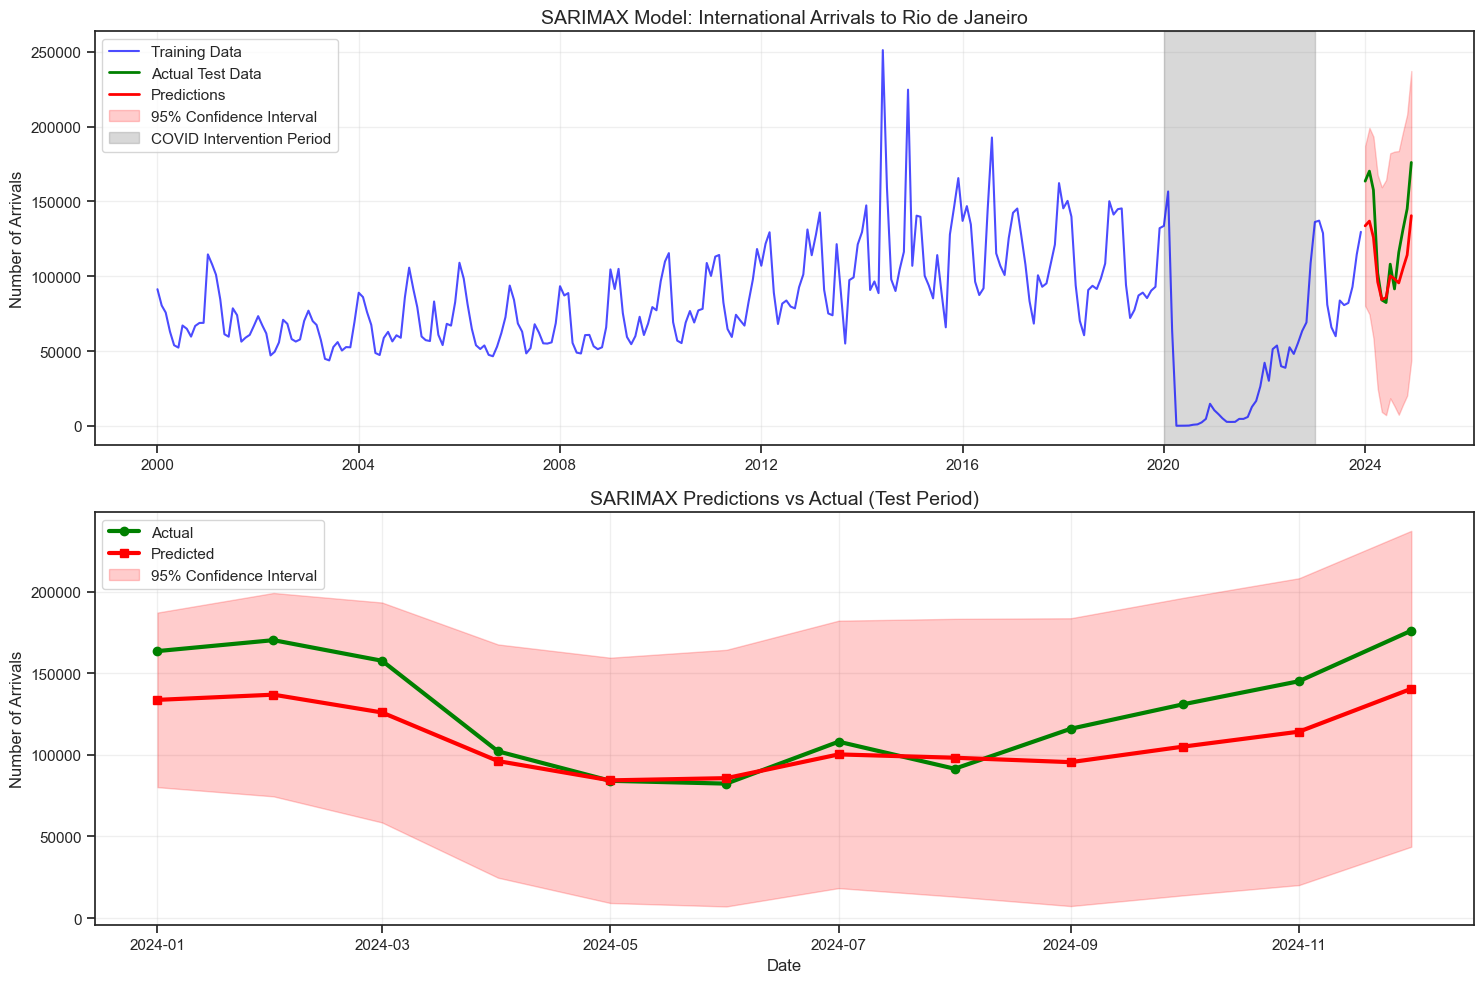


=== Detailed Predictions Comparison ===
              Actual  Predicted  Residual  Abs_Error  Pct_Error
date                                                           
2024-01-01  163598.0  133709.04  29888.96   29888.96      18.27
2024-02-01  170305.0  136901.02  33403.98   33403.98      19.61
2024-03-01  157683.0  125983.41  31699.59   31699.59      20.10
2024-04-01  102172.0   96205.88   5966.12    5966.12       5.84
2024-05-01   84116.0   84392.34   -276.34     276.34      -0.33
2024-06-01   82402.0   85747.00  -3345.00    3345.00      -4.06
2024-07-01  108089.0  100298.53   7790.47    7790.47       7.21
2024-08-01   91504.0   98257.24  -6753.24    6753.24      -7.38
2024-09-01  116003.0   95541.47  20461.53   20461.53      17.64
2024-10-01  130985.0  105054.74  25930.26   25930.26      19.80
2024-11-01  145148.0  114231.81  30916.19   30916.19      21.30
2024-12-01  176121.0  140504.64  35616.36   35616.36      20.22


In [20]:
# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Full time series with predictions
ax1.plot(train_y.index, train_y.values, label='Training Data', color='blue', alpha=0.7)
ax1.plot(test_y.index, test_y.values, label='Actual Test Data', color='green', linewidth=2)
ax1.plot(test_y.index, forecast.values, label='Predictions', color='red', linewidth=2)
ax1.fill_between(test_y.index, 
                 prediction_intervals.iloc[:, 0], 
                 prediction_intervals.iloc[:, 1], 
                 color='red', alpha=0.2, label='95% Confidence Interval')

# Highlight COVID period
covid_start = pd.Timestamp('2020-01-01')
covid_end = pd.Timestamp('2022-12-31')
ax1.axvspan(covid_start, covid_end, alpha=0.3, color='gray', label='COVID Intervention Period')

ax1.set_title('SARIMAX Model: International Arrivals to Rio de Janeiro', fontsize=14)
ax1.set_ylabel('Number of Arrivals', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Focus on test period
ax2.plot(test_y.index, test_y.values, label='Actual', color='green', linewidth=3, marker='o')
ax2.plot(test_y.index, forecast.values, label='Predicted', color='red', linewidth=3, marker='s')
ax2.fill_between(test_y.index, 
                 prediction_intervals.iloc[:, 0], 
                 prediction_intervals.iloc[:, 1], 
                 color='red', alpha=0.2, label='95% Confidence Interval')

ax2.set_title('SARIMAX Predictions vs Actual (Test Period)', fontsize=14)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Number of Arrivals', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display actual vs predicted values
comparison_df = pd.DataFrame({
    'Actual': test_y.values,
    'Predicted': forecast.values,
    'Residual': test_y.values - forecast.values,
    'Abs_Error': np.abs(test_y.values - forecast.values),
    'Pct_Error': ((test_y.values - forecast.values) / test_y.values) * 100
}, index=test_y.index)

print("\n=== Detailed Predictions Comparison ===")
print(comparison_df.round(2))

## Residual Analysis

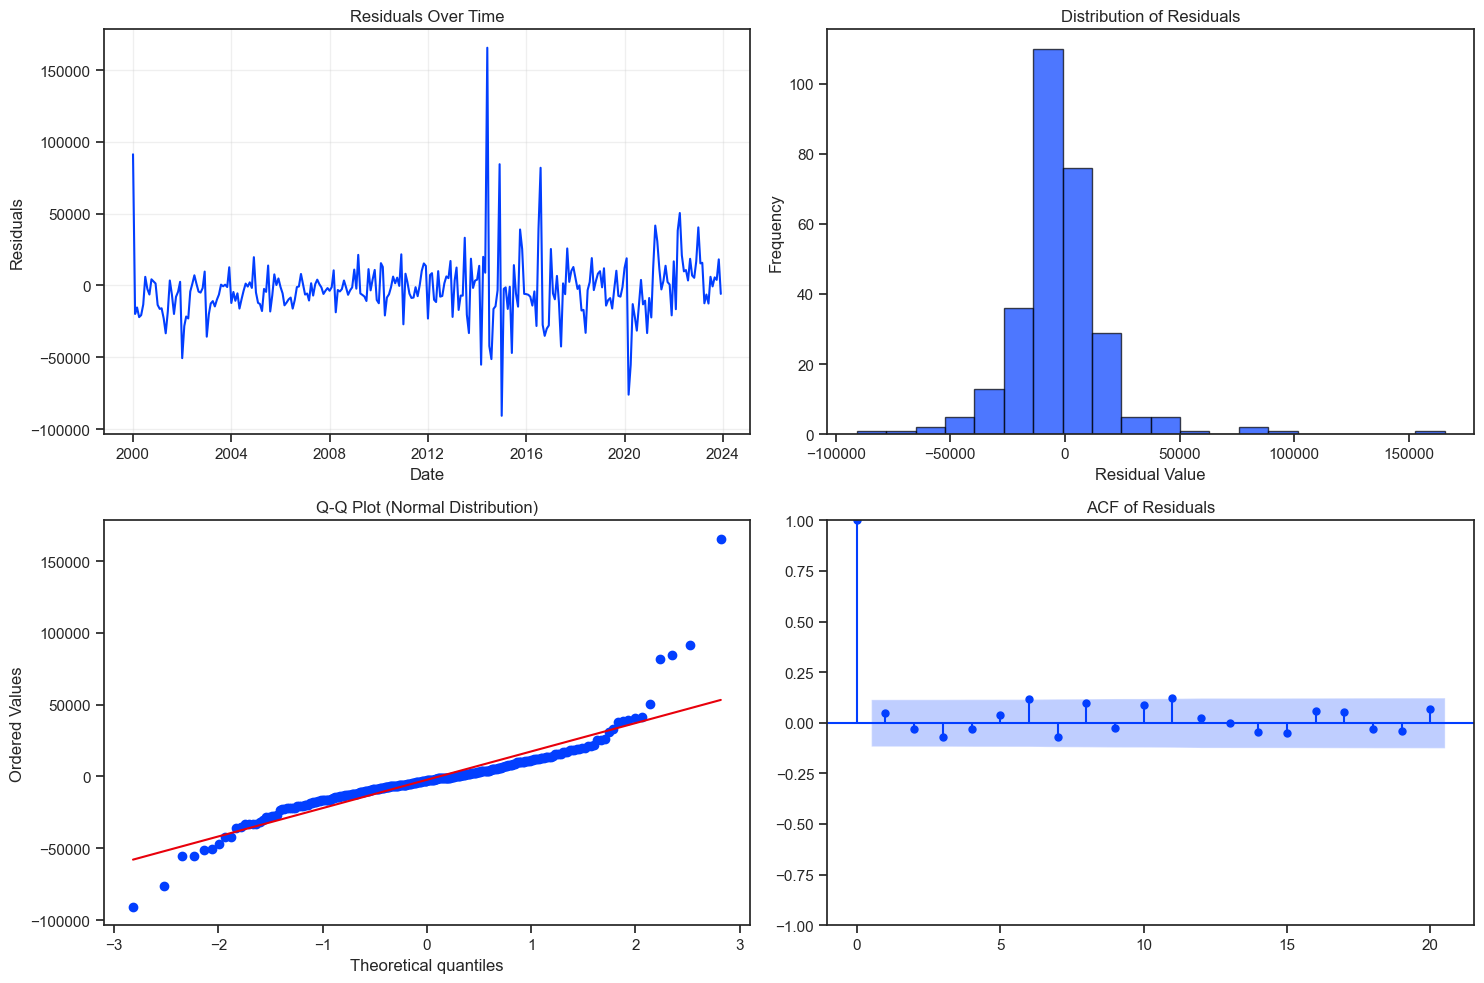

=== Residual Analysis ===
Mean of residuals: -2313.7573
Std of residuals: 21708.7778

Ljung-Box Test (p-value): 0.1737
✓ Residuals appear to be independent (p > 0.05)

Jarque-Bera Test for Normality (p-value): 0.0000
✗ Residuals may not be normally distributed (p ≤ 0.05)


In [21]:
# Residual analysis
residuals = fitted_model.resid

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot residuals over time
axes[0,0].plot(residuals.index, residuals.values)
axes[0,0].set_title('Residuals Over Time')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Residuals')
axes[0,0].grid(True, alpha=0.3)

# Histogram of residuals
axes[0,1].hist(residuals.values, bins=20, edgecolor='black', alpha=0.7)
axes[0,1].set_title('Distribution of Residuals')
axes[0,1].set_xlabel('Residual Value')
axes[0,1].set_ylabel('Frequency')

# Q-Q plot
from scipy import stats
stats.probplot(residuals.values, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot (Normal Distribution)')

# ACF of residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals.values, lags=20, ax=axes[1,1], title='ACF of Residuals')

plt.tight_layout()
plt.show()

# Statistical tests
print("=== Residual Analysis ===")
print(f"Mean of residuals: {residuals.mean():.4f}")
print(f"Std of residuals: {residuals.std():.4f}")

# Ljung-Box test for residual autocorrelation
ljung_box_result = acorr_ljungbox(residuals.values, lags=10, return_df=True)
print(f"\nLjung-Box Test (p-value): {ljung_box_result['lb_pvalue'].iloc[-1]:.4f}")
if ljung_box_result['lb_pvalue'].iloc[-1] > 0.05:
    print("✓ Residuals appear to be independent (p > 0.05)")
else:
    print("✗ Residuals may have autocorrelation (p ≤ 0.05)")

# Jarque-Bera test for normality
from scipy.stats import jarque_bera
jb_stat, jb_pvalue = jarque_bera(residuals.values)
print(f"\nJarque-Bera Test for Normality (p-value): {jb_pvalue:.4f}")
if jb_pvalue > 0.05:
    print("✓ Residuals appear to be normally distributed (p > 0.05)")
else:
    print("✗ Residuals may not be normally distributed (p ≤ 0.05)")